# Final Project Combined Preliminary EDA

In [1]:
# only need to install yellowbrick if never installed before
!pip install yellowbrick

    100% |████████████████████████████████| 286kB 4.6MB/s ta 0:00:01


## Install Reverse Geocoder
This helps us get county and city data against longtitude and latitude zillow data. Source: https://github.com/thampiman/reverse-geocoder

In [2]:
# only need to install reverse_geocoder if never installed before
!pip install reverse_geocoder

In [100]:
# import libraries
import numpy as np
from numpy import errstate,isneginf
from scipy import stats
import pandas as pd
from time import time
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re as re
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import gauntlet
# import gauntlet
import reverse_geocoder as rg
sns.set(style = 'white')

%matplotlib inline

## Read in Data

In [4]:
# load the data 
#train_2016 = pd.read_csv("train_2016_v2.csv")
#properties_2016 = pd.read_csv("properties_2016.csv")

# Ray reading in data from a different file location - comment this out if you need to change it please
train_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/train_2016_v2.csv")
properties_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/properties_2016.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory Data Analysis

In [5]:
# look at properties 2016 dataframe
properties_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
storytypeid,1624,NaN,NaN,NaN,7,0,7,7,7,7,7
basementsqft,1628,NaN,NaN,NaN,646.883,538.793,20,272,534,847.25,8516
yardbuildingsqft26,2647,NaN,NaN,NaN,278.297,369.732,10,96,168,320,6141
fireplaceflag,5163,1,True,5163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,6061,NaN,NaN,NaN,7.20261,2.43629,2,7,7,7,27
typeconstructiontypeid,6747,NaN,NaN,NaN,5.99956,0.38405,4,6,6,6,13
finishedsquarefeet13,7672,NaN,NaN,NaN,1178.9,357.073,120,960,1296,1440,2688
buildingclasstypeid,12629,NaN,NaN,NaN,3.72595,0.5017,1,3,4,4,5
decktypeid,17096,NaN,NaN,NaN,66,0,66,66,66,66,66
finishedsquarefeet6,22001,NaN,NaN,NaN,2414.34,7695.3,117,1079,1992,3366,952576


In [7]:
# look at train 2016 dataframe
train_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
parcelid,90275,NaN,NaN,NaN,1.29847e+07,2.50451e+06,1.07117e+07,1.15595e+07,1.25473e+07,1.42276e+07,1.62961e+08
logerror,90275,NaN,NaN,NaN,0.0114572,0.161079,-4.605,-0.0253,0.006,0.0392,4.737
transactiondate,90275,352,2016-07-29,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Convert the transactiondate column to a datetime
train_2016.transactiondate = pd.to_datetime(train_2016.transactiondate, infer_datetime_format=True)
print(train_2016.dtypes)

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
dtype: object


## Merge train + properties data

In [10]:
# merge the logerror and transactiondate the properties and filter to only 2016 data
combined_df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
combined_df.set_index(keys='parcelid',inplace=True)

In [11]:
# convert Lat/Long to actual Lat/Long
# note - run this cell one-time or latitude/longtitude will continue to divide by 1e6
combined_df['latitude'] = combined_df['latitude']/1e6
combined_df['longitude'] = combined_df['longitude']/1e6

# combine latitude and longtitude into one column
combined_df['latlng'] = combined_df['latitude'].map(str) + ',' + combined_df['longitude'].map(str)

## Map Latitude + Longitude to City & County

In [12]:
# lookup lat/long locations
coordinates = combined_df["latlng"].apply(lambda x: tuple(x.split(',')))
results = rg.search(coordinates.tolist())

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

combined_df['city'] = city
combined_df['county'] = county

# create a combined variable for better categorization
combined_df['county_city'] = list(zip(county, city))
combined_df['county_city'] = combined_df['county_city'].astype('category')

Loading formatted geocoded file...


In [13]:
# verify that city, county, and county_city are pulled in correctly
combined_df.head(2)

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,latlng,city,county,county_city
parcelid,,,,,,,,,,,,,,,,,,,,,
10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0276,2016-01-01,"34.144442,-118.654084",Hidden Hills,Los Angeles County,"(Los Angeles County, Hidden Hills)"
10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.1684,2016-01-01,"34.14043,-118.625364",Calabasas,Los Angeles County,"(Los Angeles County, Calabasas)"


## Only keep counties in Los Angeles, Orange and Ventura, California. 
### (Per Zillow you are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.)

In [14]:
print(combined_df['county'].value_counts())

Los Angeles County       59641
Orange County            22972
Ventura County            7535
San Bernardino County      115
Kern County                  9
Santa Barbara County         3
Name: county, dtype: int64


In [15]:
combined_df = combined_df[(combined_df['county'] == 'Los Angeles County') | (combined_df['county'] == 'Orange County') | (combined_df['county'] == 'Ventura County')]


In [16]:
print(combined_df['county'].value_counts())

Los Angeles County    59641
Orange County         22972
Ventura County         7535
Name: county, dtype: int64


## We end up with 90,148 rows of data

## Now we look at the continuous data with the highest correlations

In [25]:
# create a deep copy of the merged dataframe (combined_df) above
ray_df = combined_df.copy(deep = True)

In [18]:
ray_df.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

In [19]:
ray_df['airconditioningtypeid'] = ray_df['airconditioningtypeid'].apply(str)


In [26]:
display(ray_df.groupby(['county'],axis = 0).count()[['airconditioningtypeid']])

,airconditioningtypeid
county,
Los Angeles County,21352
Orange County,2907
Ventura County,43


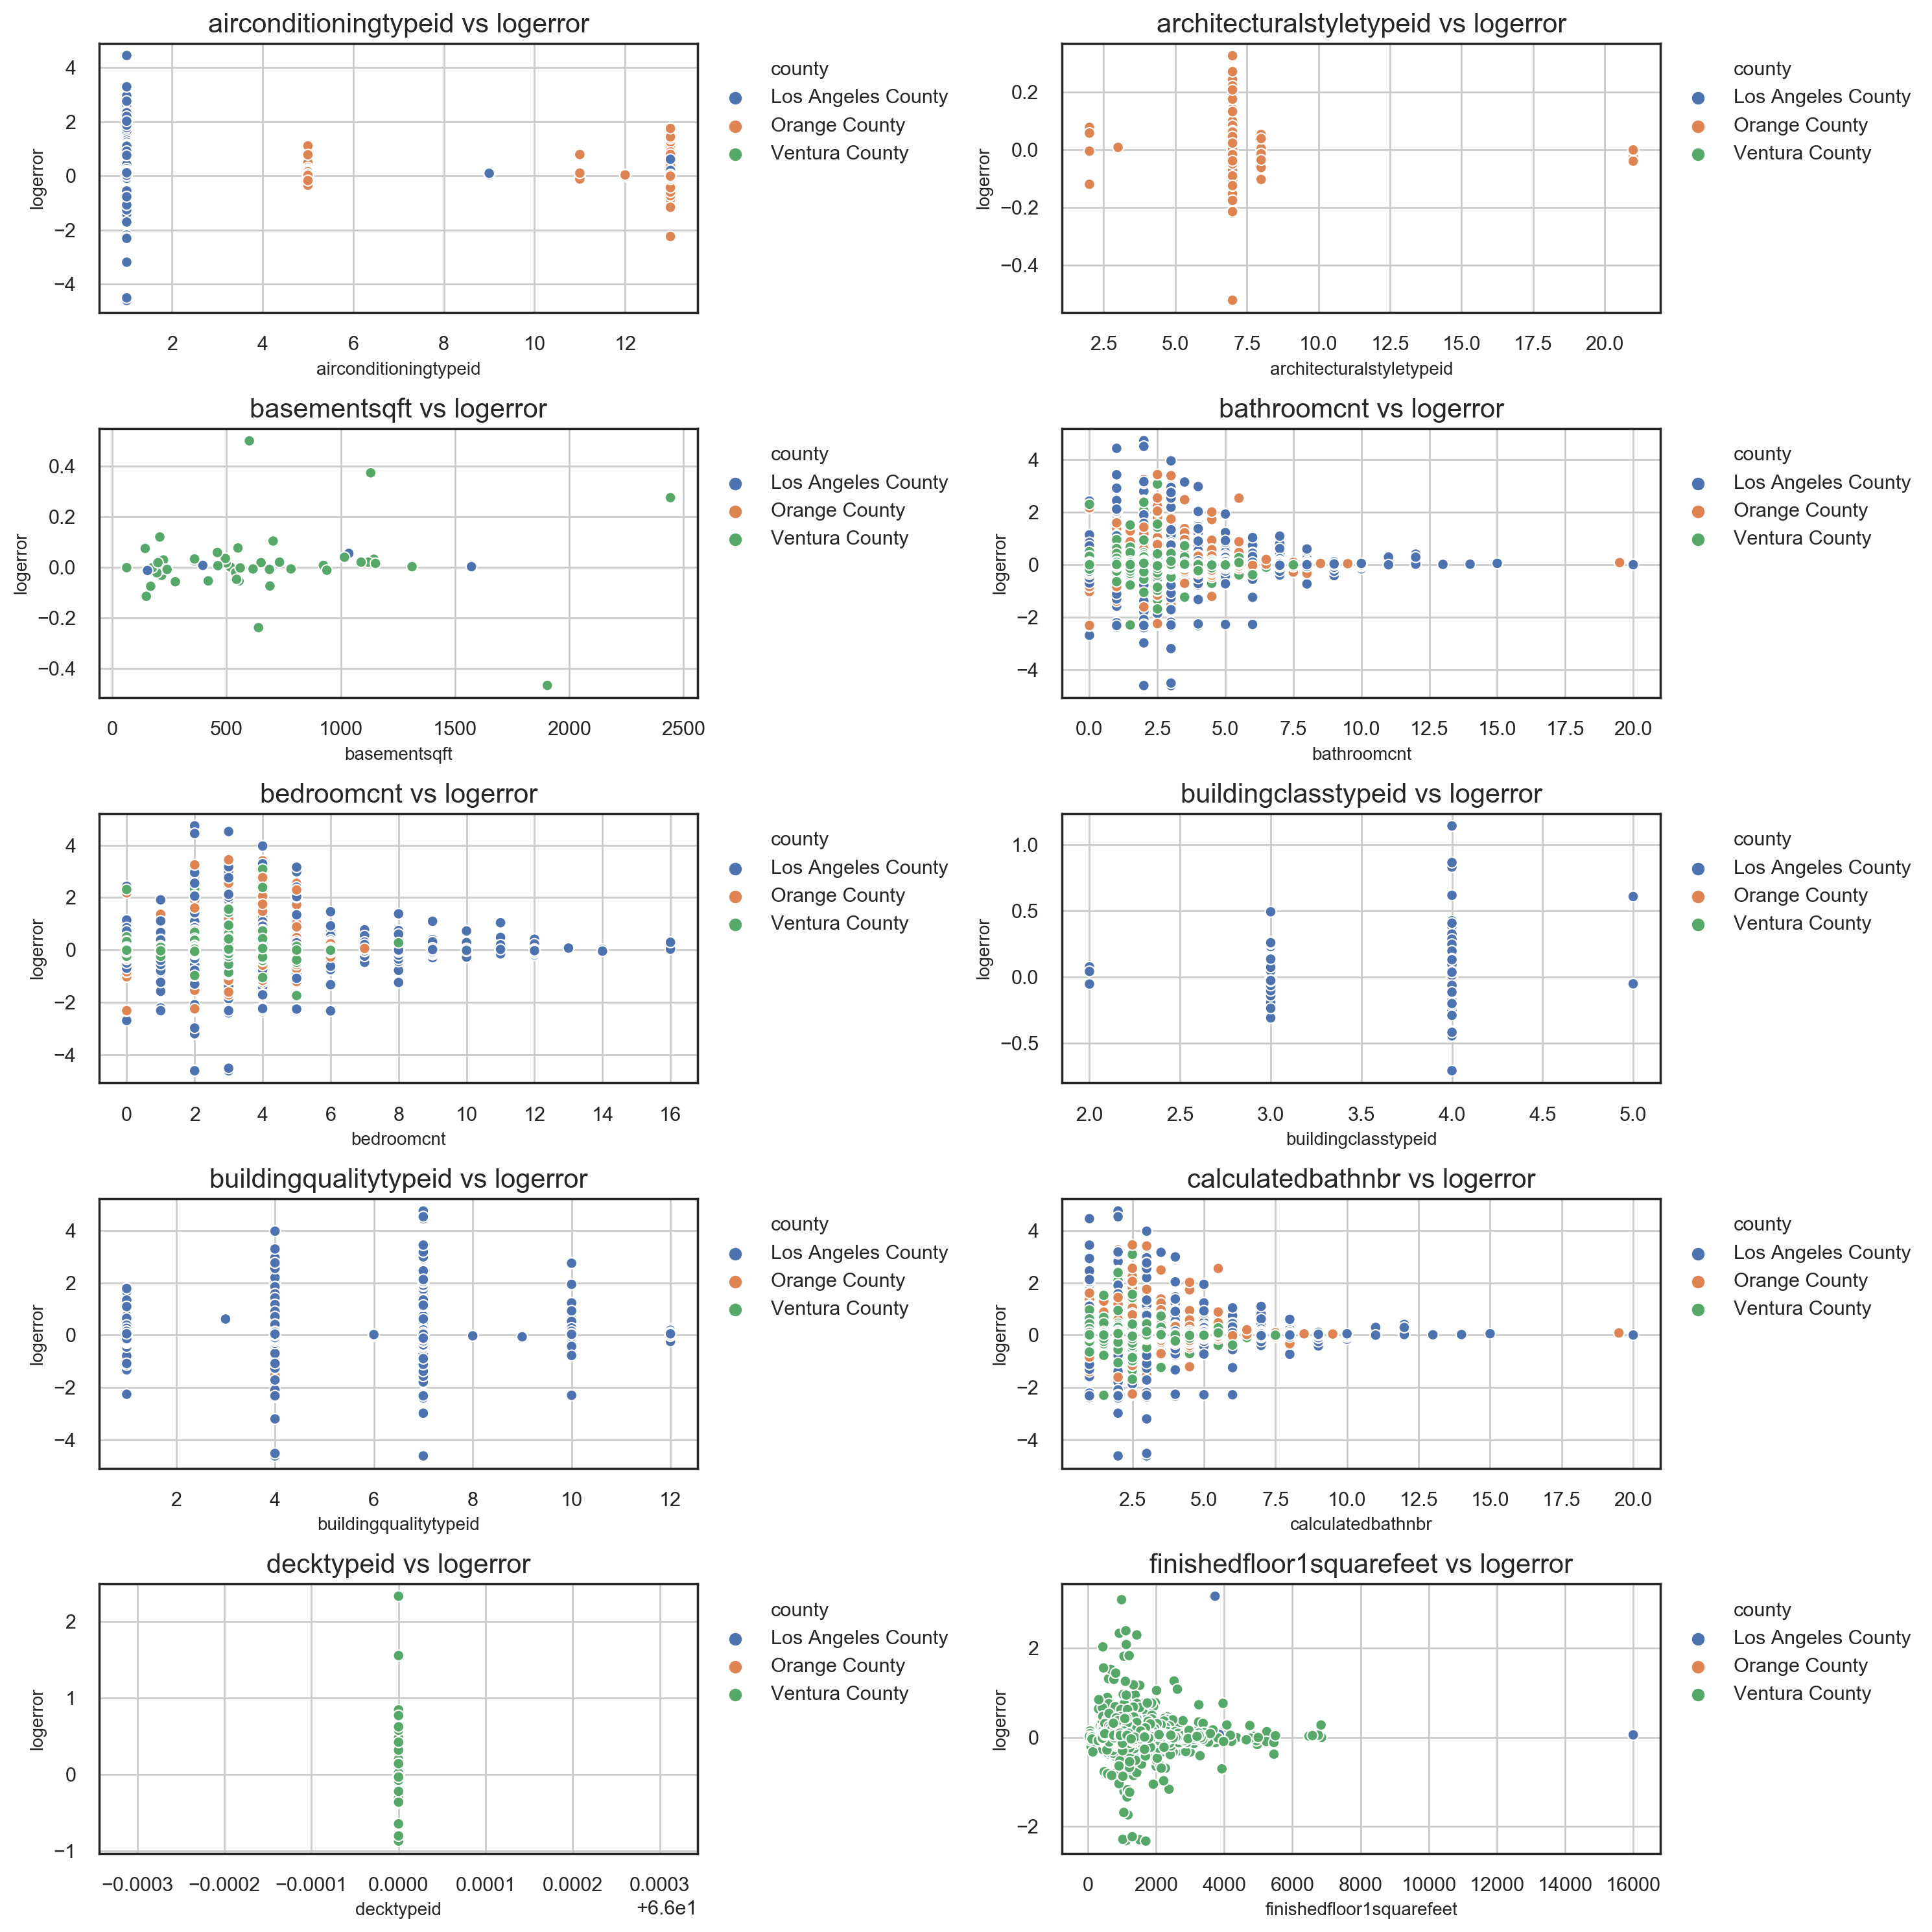

In [115]:
#DOESNT WORK %matplotlib notebook
#fig, ax = plt.subplots(5,5, figsize = (20,30))
    

#Beautiful plots referenced: https://imaddabbura.github.io/post/kmeans_clustering/

fig, ax = plt.subplots(5,2, figsize = (15,15), dpi = 200)

n_iter = 10
ax = np.ravel(ax)
for i in range(n_iter):
    sns.scatterplot(x=ray_df.columns[i], y='logerror', data=ray_df, hue = 'county', ax = ax[i])
    ax[i].set_xlabel(ray_df.columns[i], fontsize = 10)
    ax[i].set_ylabel('logerror', fontsize = 10)
    ax[i].set_title('{0} vs logerror'.format(ray_df.columns[i]), fontsize = 15)
    ax[i].legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.5)
    ax[i].grid()

plt.tight_layout()
#         #Plot the data
#         targets = [1, 0]
#         colors = ['b', 'r']
#         for target, color in zip(targets,colors):
#             indicesToKeep = final_df['poisonous'] == target
#             ax[i].scatter(final_df.loc[indicesToKeep, 'principal component 1']
#                        , final_df.loc[indicesToKeep, 'principal component 2']
#                        , c = color
#                        , s = 50)

In [28]:
display(ray_df.groupby(['county'],axis = 0).count()[['architecturalstyletypeid']])

,architecturalstyletypeid
county,
Los Angeles County,1
Orange County,182
Ventura County,0


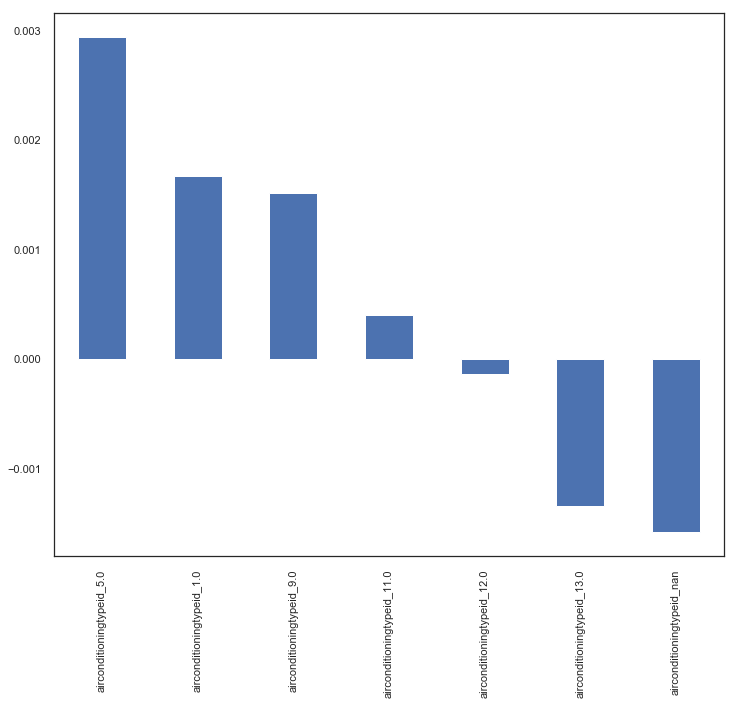

In [23]:
plt.figure(figsize=(12,10))
pd.get_dummies(ray_df[['logerror','airconditioningtypeid']]).corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

In [16]:
def cat_or_float(df):
    categorical_col = []
    continuous_col = []
    for i in df.columns:
        if type(df[i].iloc[1]) == str:
            categorical_col.append(i)
        if type(df[i].iloc[1]) == np.float64:
            continuous_col.append(i)
    return continuous_col, categorical_col

In [17]:
cont_col, cat_col = cat_or_float(ray_df)

In [18]:
display(cont_col[:10])
display(cat_col)

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet']

['propertycountylandusecode', 'propertyzoningdesc', 'latlng', 'city', 'county']

In [19]:
# add logerror into the cat_col
for i in cat_col:
    print('categorical column {0} contains {1} unique values for dummy columns'.format(i, len(ray_df[i].unique())))
cat_col.append('logerror')

categorical column propertycountylandusecode contains 109 unique values for dummy columns
categorical column propertyzoningdesc contains 2141 unique values for dummy columns
categorical column latlng contains 84439 unique values for dummy columns
categorical column city contains 217 unique values for dummy columns
categorical column county contains 3 unique values for dummy columns


In [20]:
print(ray_df['city'].head())

parcelid
10754147       Hidden Hills
10759547          Calabasas
10843547     Ladera Heights
10859147       Sherman Oaks
10879947    North Hollywood
Name: city, dtype: object


In [21]:
cat_df = ray_df[['county','logerror']]
con_df = ray_df[cont_col]

In [22]:
# Turns categorical data into dummy binary columns
df_dummies_cat = pd.get_dummies(cat_df)

In [23]:
print(df_dummies_cat.columns)

Index(['logerror', 'county_Los Angeles County', 'county_Orange County',
       'county_Ventura County'],
      dtype='object')


## <font color=green> [Ray] Going to plot corr of continuous variables (53 variables)</font>

In [24]:
print(*con_df.columns, sep=" - ")

airconditioningtypeid - architecturalstyletypeid - basementsqft - bathroomcnt - bedroomcnt - buildingclasstypeid - buildingqualitytypeid - calculatedbathnbr - decktypeid - finishedfloor1squarefeet - calculatedfinishedsquarefeet - finishedsquarefeet12 - finishedsquarefeet13 - finishedsquarefeet15 - finishedsquarefeet50 - finishedsquarefeet6 - fips - fireplacecnt - fullbathcnt - garagecarcnt - garagetotalsqft - heatingorsystemtypeid - latitude - longitude - lotsizesquarefeet - poolcnt - poolsizesum - pooltypeid10 - pooltypeid2 - pooltypeid7 - propertylandusetypeid - rawcensustractandblock - regionidcity - regionidcounty - regionidneighborhood - regionidzip - roomcnt - storytypeid - threequarterbathnbr - typeconstructiontypeid - unitcnt - yardbuildingsqft17 - yardbuildingsqft26 - yearbuilt - numberofstories - structuretaxvaluedollarcnt - taxvaluedollarcnt - assessmentyear - landtaxvaluedollarcnt - taxamount - taxdelinquencyyear - censustractandblock - logerror


In [25]:
def col_append(col_ind):
    col = cont_col[col_ind:col_ind+10]
    col.append('logerror')
    return col

In [26]:
df1, df2, df3, df4, df5 = con_df[col_append(0)], con_df[col_append(10)], con_df[col_append(20)], con_df[col_append(30)], con_df[col_append(40)]
df6 = con_df[con_df.columns[50:]]

## From the chart below, we see a log error has a higher correlation with architecturalstyletypeid and basementsqft 

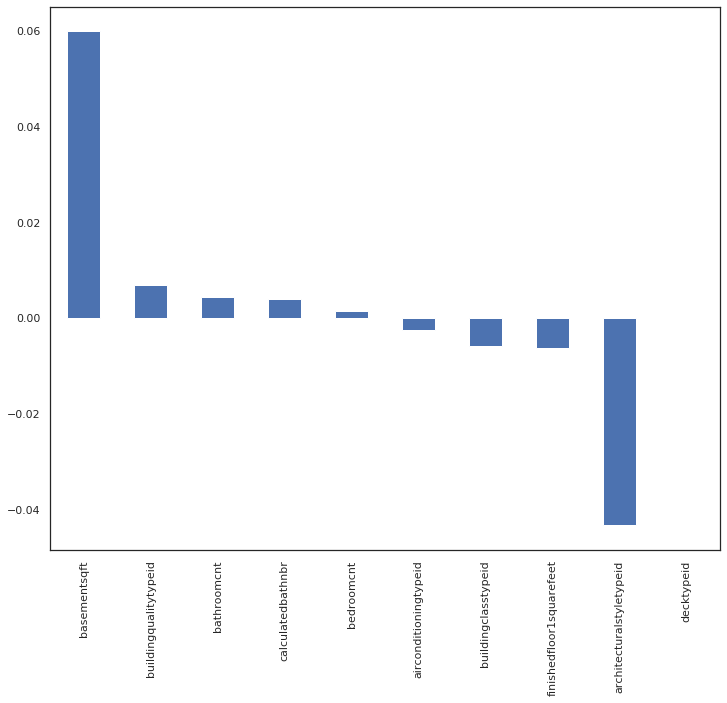

In [27]:
# df1 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df1.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## From plotting the scatter plot we see that 1, the data is only populated for Ventura County and Los Angeles County. 2, there are only 51 examples of data. Log error does not seem to deviate too much.

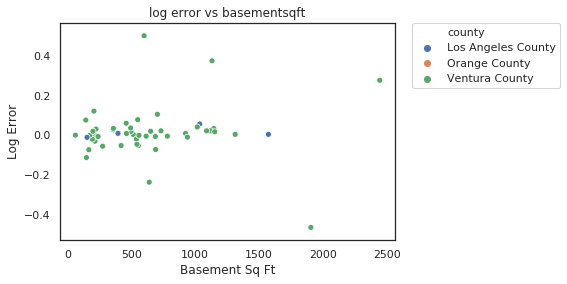

,basementsqft
county,
Los Angeles County,4
Orange County,0
Ventura County,47


In [28]:
xvar = 'basementsqft'
sns.scatterplot(x = 'basementsqft', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs basementsqft')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Basement Sq Ft")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## From the plot below, we see something similar to above, so we can also drop this column.

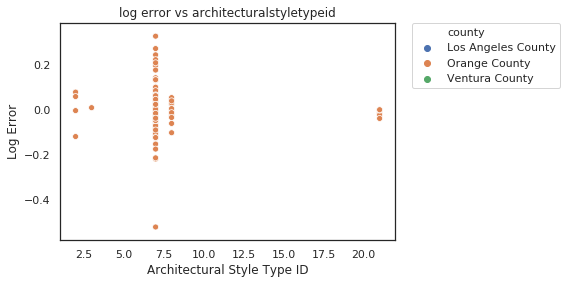

,architecturalstyletypeid
county,
Los Angeles County,1
Orange County,182
Ventura County,0


In [29]:
xvar = 'architecturalstyletypeid'
sns.scatterplot(x = 'architecturalstyletypeid', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs architecturalstyletypeid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Architectural Style Type ID")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

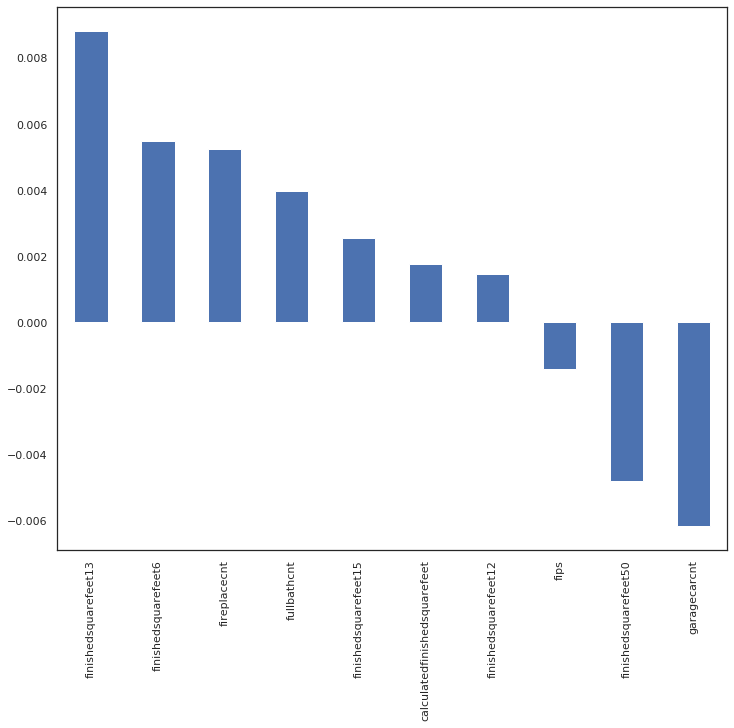

In [30]:
# df2 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df2.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Now looking at garage car counts, we see there's quite a bit of log error deviation around the 1-4 car garages, focused on Orange County and Ventura County. This presents an opportunity for an interaction feature multiplying the county categoricals with this garage cat count

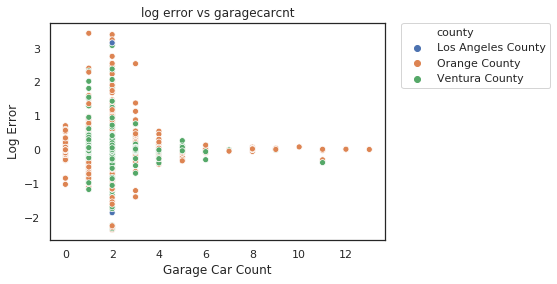

,garagecarcnt
county,
Los Angeles County,208
Orange County,20421
Ventura County,6798


In [31]:
xvar = 'garagecarcnt'
sns.scatterplot(x = 'garagecarcnt', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs garagecarcnt')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Garage Car Count")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## Same with 1-2 fireplaces. Primarily around OC/VC. Same idea here.

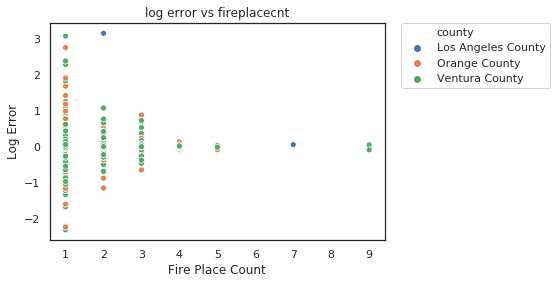

,fireplacecnt
county,
Los Angeles County,83
Orange County,4657
Ventura County,5181


In [32]:
sns.scatterplot(x = 'fireplacecnt', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs fireplacecnt')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Fire Place Count")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[['fireplacecnt']])

##  Federal Information Processing Standard code. Every single home has a value. We see counties each have their own unique fips code... maybe some opportunity here. Also, should we remove those LA County with FIPS in 6110 and 6060? Can someone look into this.

## AB - Looked into it. 6110 and 6060 are not valid FIPS codes. FIPS codes are just county IDs and we should be able to drop this column

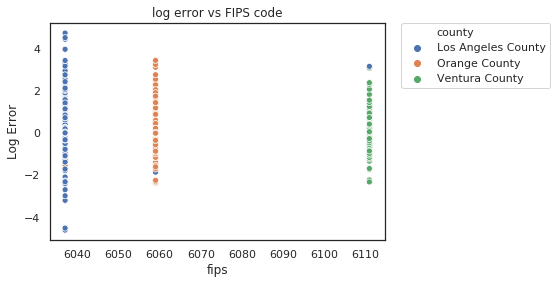

,fips
county,
Los Angeles County,59641
Orange County,22972
Ventura County,7535


In [33]:
xvar = 'fips'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs FIPS code')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

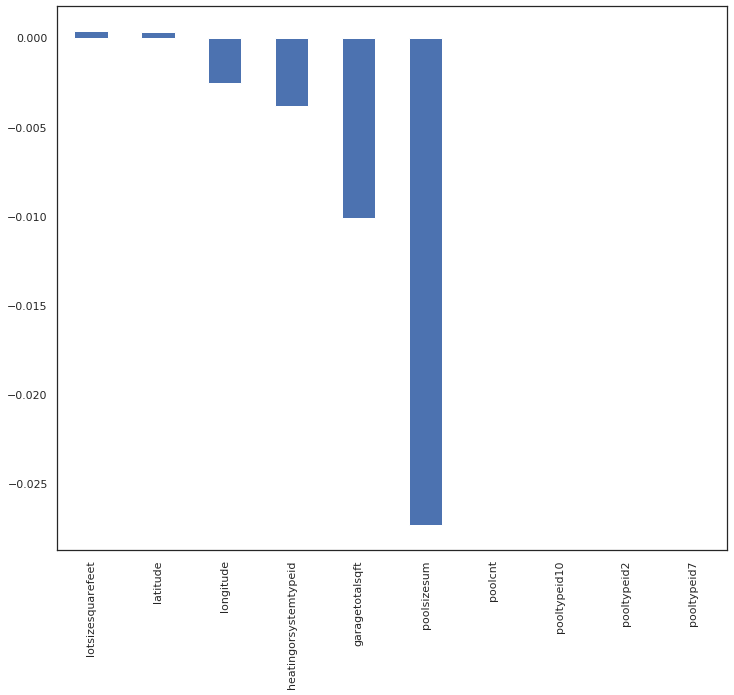

In [34]:
# df3 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df3.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## A lot of spread here, primarily OC/VC.

27427


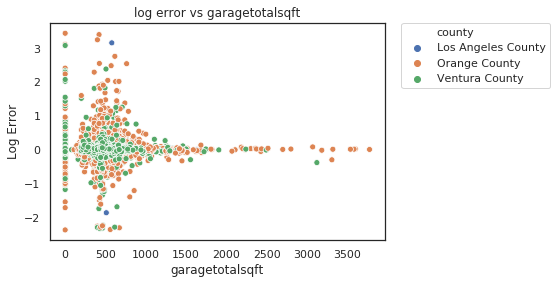

,garagetotalsqft
county,
Los Angeles County,208
Orange County,20421
Ventura County,6798


In [35]:
xvar = 'garagetotalsqft'
print(ray_df[xvar].count())
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs garagetotalsqft')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## Poolsizesum doesn't contribute that much error, there are some outliers. We should investigate further why there's an outlier but doesn't have many records.

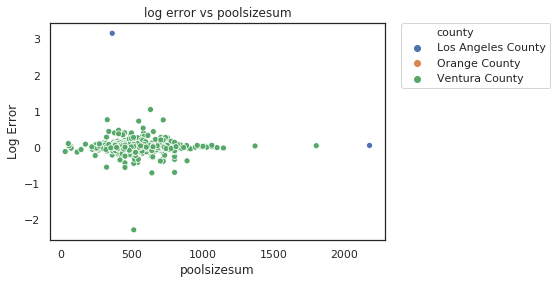

,poolsizesum
county,
Los Angeles County,12
Orange County,0
Ventura County,893


In [36]:
xvar = 'poolsizesum'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs poolsizesum')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## This looks pretty important and a good categorical feature. We should actually figure out how we should treat these, this is more categorical than continuous.

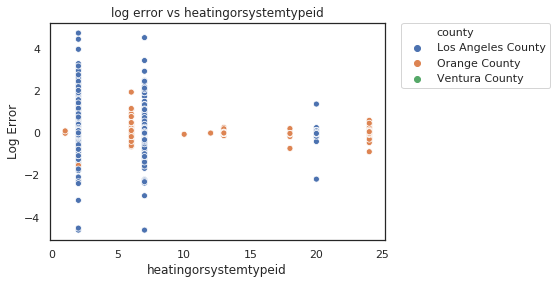

,heatingorsystemtypeid
county,
Los Angeles County,51712
Orange County,2251
Ventura County,49


In [37]:
xvar = 'heatingorsystemtypeid'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs heatingorsystemtypeid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

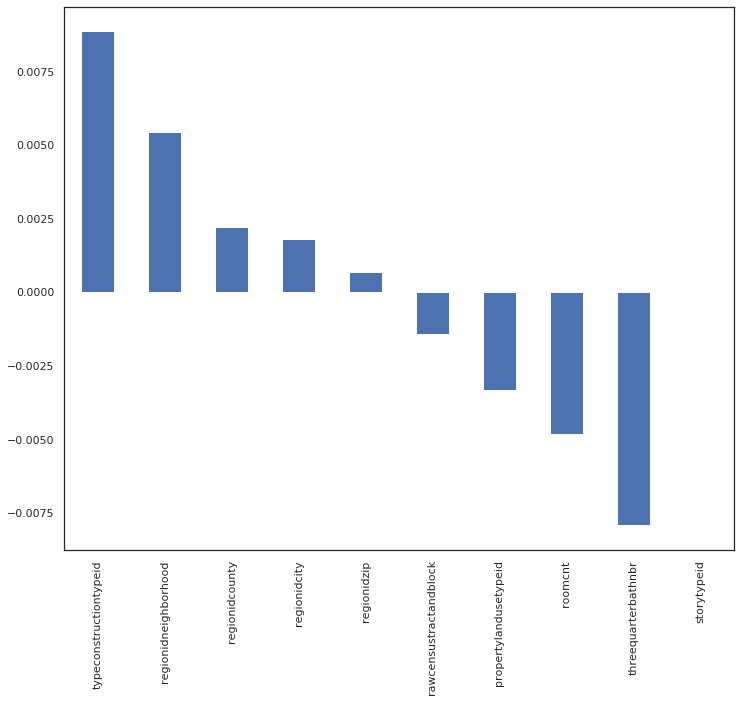

In [38]:
# df4 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df4.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Huge amounts of error for LA with a room count of 0's (Studios)... Outlier of a place with 80+ rooms.... probably a bad data point.

### AB - don't think it's a bad data point - I found at least two homes on Zillow that are 20 bed/25+ bath, so it seems reasonable they might have 80 total rooms

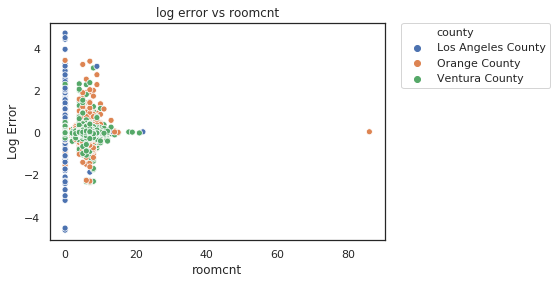

,roomcnt
county,
Los Angeles County,59640
Orange County,22972
Ventura County,7535


In [39]:
xvar = 'roomcnt'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs roomcnt')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## Not really sure what this means.... probably not important

### AB - 3/4 bath means it has a shower but not a tub. Probably could be added to the full bath count.

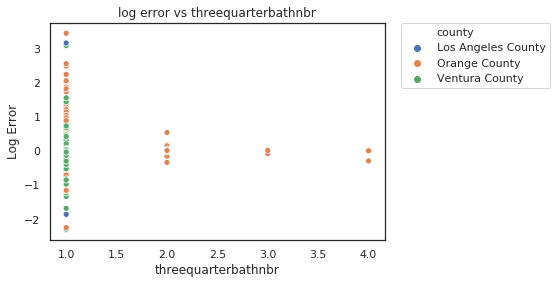

,threequarterbathnbr
county,
Los Angeles County,67
Orange County,7437
Ventura County,2164


In [40]:
xvar = 'threequarterbathnbr'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs threequarterbathnbr')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

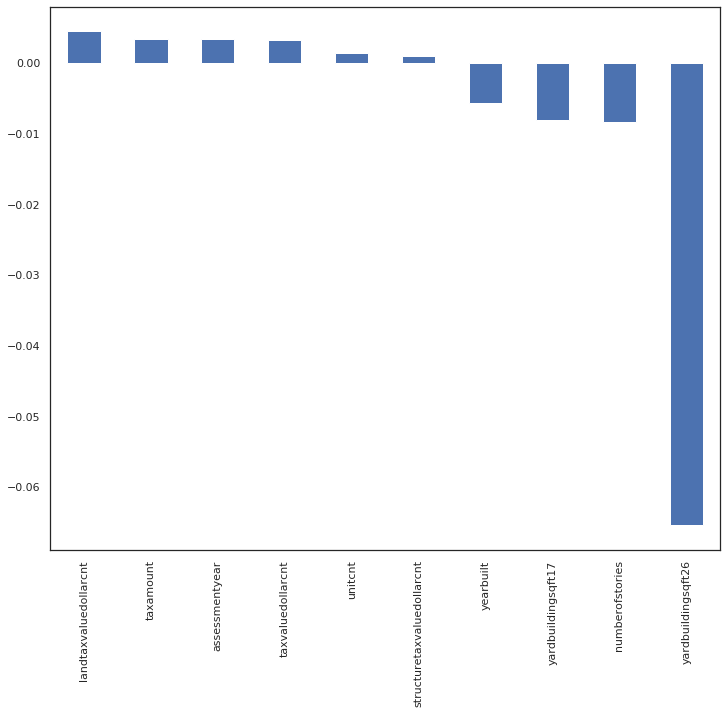

In [41]:
# df5 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df5.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Remove yardbuildingsqft26

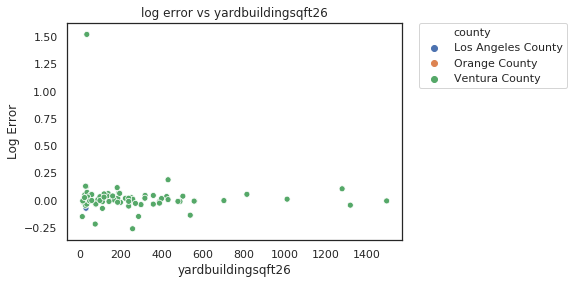

,yardbuildingsqft26
county,
Los Angeles County,1
Orange County,0
Ventura County,81


In [42]:
xvar = 'yardbuildingsqft26'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs yardbuildingsqft26')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

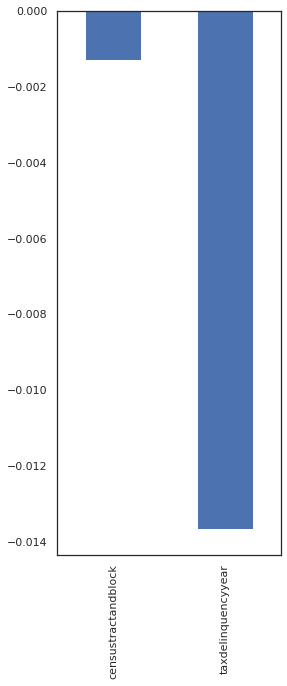

In [43]:
# df6 - get Correlation of logerror with other variables:
plt.figure(figsize=(4,10))
df6.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## More recent the year, more logerror.

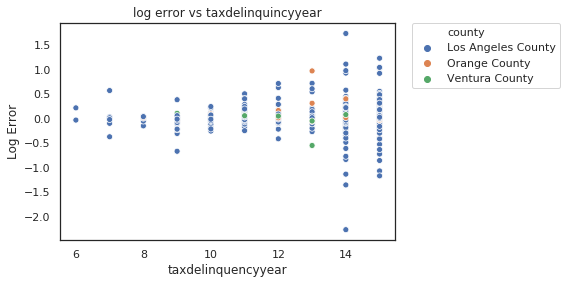

,taxdelinquencyyear
county,
Los Angeles County,1510
Orange County,190
Ventura County,40


In [44]:
xvar = 'taxdelinquencyyear'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs taxdelinquincyyear')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

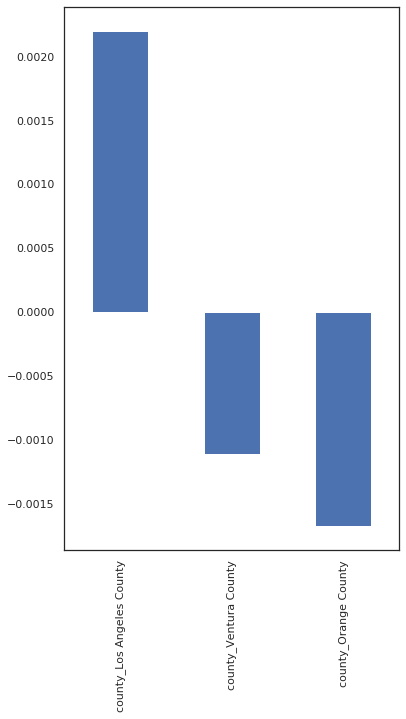

In [45]:
plt.figure(figsize=(6,10))
df_dummies_cat.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Los Angeles has the most log error and records.

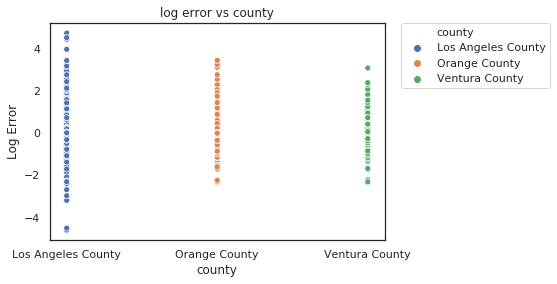

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,latlng,city,county_city
county,,,,,,,,,,,,,,,,,,,,,
Los Angeles County,21352,1,4,59641,59641,440,57143,57714,14,70,...,58776,59381,1510,1510,57887,59641,59641,59641,59641,59641
Orange County,2907,182,0,22972,22972,0,754,21658,0,0,...,22311,22819,190,190,22668,22972,22972,22972,22972,22972
Ventura County,43,0,47,7535,7535,0,49,6926,558,6850,...,7225,7333,40,40,7405,7535,7535,7535,7535,7535


In [46]:
xvar = 'county'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs county')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'], axis = 0).count())

# Drop columns

## Fix the things we know we should do

In [47]:
# drop columns that are duplicative
#      FIPS - described by county
#      storytypeid - only ever set to 7-basement; fully represented by the basementsqft column

combined_df.drop(labels=['storytypeid','fips'], axis=1,inplace=True)

In [48]:
#combined_df.dtypes.transpose()

In [49]:
# standardize and convert data to 1 or 0
def convert_yn(x):
    if x in ['True','Y']:
        return 1
    return 0

In [50]:
for col in ['hashottuborspa','taxdelinquencyflag','fireplaceflag']:
    combined_df[col] = combined_df[col].astype('str').map(convert_yn)

## Filter down dataset to just non-categorical values
### Amy to Ray: I'm filtering out the categorical variables here since I figured I'd leave those for you to analyze separately

## Going to convert categorical columns now 

## Not converting the one's we've decided to drop: pooltypeid2, pooltypeid10

In [ ]:
# # Should we consider just converting this to yes or no ? 1/0.  
# 1	Central Yes
# 2	Chilled Water No
# 3	Evaporative Cooler No
# 4	Geo Thermal? No
# 5	None No
# 6	Other No
# 7	Packaged AC Unit Yes
# 8	Partial No
# 9	Refrigeration Yes?
# 10	Ventilation No?
# 11	Wall Unit Yes
# 12	Window Unit Yes
# 13	Yes Yes
combined_df['airconditioningtypeid'] = combined_df['airconditioningtypeid'].apply(str)

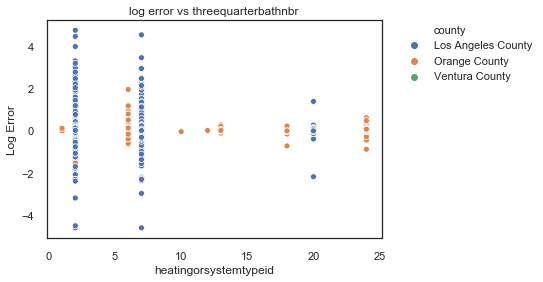

In [32]:
xvar = 'heatingorsystemtypeid'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs threequarterbathnbr')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()

In [30]:
combined_df.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

In [51]:
# Filter down to just the columns w/numeric values
# Some of these are actually categorical. Leave for Ray to analyze
numeric_df = combined_df.select_dtypes(include=['float64','int64']).drop(labels=['airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                        'buildingqualitytypeid', 'heatingorsystemtypeid', 'latitude', 'longitude',
                       'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                        'regionidneighborhood','regionidzip','typeconstructiontypeid','censustractandblock',
                        'bathroomcnt','bedroomcnt','assessmentyear', 'roomcnt', 'hashottuborspa',
                        'taxdelinquencyflag','fireplaceflag'], axis=1)

In [52]:
def analyze_cols(df):
    """ Takes a data frame and for each column calculates the mean and standard 
        deviation of absolute logerror for listings with this home populated 
        as well as without this home populated.
        
        Performs a two-tailed independent t-test to determine if the listings with 
        this column populated have a different logerror than those without it populated.
        
        Returns a dataframe with all values for each column
    """
    out_list = []
    for col in df.columns:
        if col == "logerror":
            continue
            
        my_dict = {}
        
        # Split the df based on whether the col is populated and just keep absolute value of logerror
        pop_df = np.abs(df[(df[col].notna())]['logerror'])
        nan_df = np.abs(df[(df[col].isnull())]['logerror'])

        # Print out the mean and st dev logerror
        my_dict["col"] = col
        my_dict["n"] = pop_df.shape[0]
        my_dict["mean_pop"] = pop_df.mean()
        my_dict["std_pop"] = pop_df.std()
        my_dict["mean_nan"] = nan_df.mean()
        my_dict["std_nan"] = nan_df.std()
        my_dict['p_val'] = stats.ttest_ind(pop_df,nan_df).pvalue
        
        out_list.append(my_dict)
        
    return pd.DataFrame(out_list)[['col','n','mean_pop','mean_nan','std_pop','std_nan','p_val']].sort_values(by="n").set_index('col')

In [53]:
analyze_cols(numeric_df)

,n,mean_pop,mean_nan,std_pop,std_nan,p_val
col,,,,,,
basementsqft,51,0.065247,0.068440,0.110930,0.146256,0.876114
yardbuildingsqft26,82,0.059695,0.068447,0.171019,0.146214,0.588057
finishedsquarefeet13,249,0.068342,0.068439,0.100739,0.146345,0.991657
decktypeid,572,0.077908,0.068378,0.158115,0.146158,0.120260
finishedsquarefeet6,658,0.058308,0.068513,0.099169,0.146526,0.074509
poolsizesum,905,0.070720,0.068415,0.161899,0.146071,0.637176
pooltypeid2,969,0.068871,0.068434,0.130858,0.146397,0.926259
pooltypeid10,1053,0.066811,0.068458,0.119985,0.146521,0.716339
taxdelinquencyyear,1740,0.072253,0.068363,0.142779,0.146305,0.271946


## <font color=red>Based on the output, I would suggest dropping columns that are less than 5% populated (n < 4,507) AND have a p-value > 0.5.</font>

This would mean dropping: basementsqft, yardbuildingsqft26, finishedsquarefeet13, poolsizesum, pooltypeid2, pooltypeid10

## Save normalization/interoplation for after we analyze which columns have the most variation

In [54]:
# interpolate missing values for the following columns
#interpolate_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', \
#                      'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', \
#                      'garagetotalsqft']

# default interpolation method is linear, let's just stick with that
#for column in interpolate_columns:
#    combined_df[column].interpolate(inplace=True)

In [55]:
# Commenting out for now - will normalize instead of using log transform
# transform columns with very large st dev to log
#log_transform_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', \
#                        'taxamount', 'lotsizesquarefeet']

#eps = 1e-6
#for column in log_transform_columns:
#    combined_df[column] = np.log10(combined_df[column] + eps)


In [56]:
# normalize continuous variables
#normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', \
#                     'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17', \
#                    'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt',
#                    'taxamount']


#for column in normalize_columns:
#    combined_df[column] = (combined_df[column] - combined_df[column].mean()) / combined_df[column].std()

## Train Data EDA

## Transaction Counts and Avg logerror by Month

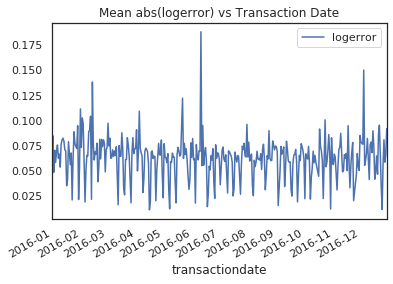

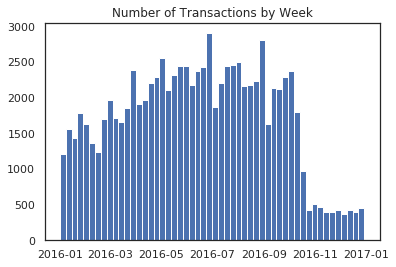

In [57]:
# plot logerrors over time
plt_df = combined_df[['transactiondate','logerror']].copy()
plt_df['transactiondate'] = plt_df.transactiondate#.astype('datetime64[M]')
plt_df['logerror'] = np.abs(plt_df.logerror)
g = plt_df.groupby(['transactiondate']).mean()
g.plot()
plt.title("Mean abs(logerror) vs Transaction Date")
plt.show()
plt.hist(plt_df.transactiondate,bins=52)
plt.title("Number of Transactions by Week")
plt.show()

## <font color=red> This is the start of feature exploration, selection, and engineering... </font>

## Split dataset into train, dev, and test and filter to July 2016

In [58]:
# Set the columns to filter out of the dataset here
excl_cols = ['basementsqft', 'yardbuildingsqft26', 'finishedsquarefeet13', 'poolsizesum', 'pooltypeid2', 'pooltypeid10']

In [59]:
# split the dataset into train (60%), dev (20%), and test (20%)
# Set a random seed (623) to keep our dataset consistent between runs
# Only use data from July 2016

df = shuffle(combined_df, random_state=623)
if excl_cols is not None:
    df.drop(labels = excl_cols, axis=1, inplace=True)

df = df[(df['transactiondate'] >= '2016-07-01') & (df['transactiondate'] <= '2016-07-31')]

i_logerror = df.columns.get_loc("logerror")

train_data, train_labels = df.iloc[:int(len(df)*0.6), np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[:int(len(df)*0.6),i_logerror:(i_logerror+1)].values
df_train = df.iloc[:int(len(df)*0.6), :]
dev_data, dev_labels = df.iloc[int(len(df)*0.6):int(len(df)*0.8), np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[int(len(df)*0.6):int(len(df)*0.8),i_logerror:(i_logerror+1)].values
df_dev = df.iloc[int(len(df)*0.6):int(len(df)*0.8), :]
test_data, test_labels = df.iloc[int(len(df)*0.8):, np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[int(len(df)*0.8):,i_logerror:(i_logerror+1)].values
df_test = df.iloc[int(len(df)/2):, :]

/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Histograms of features in our train dataset

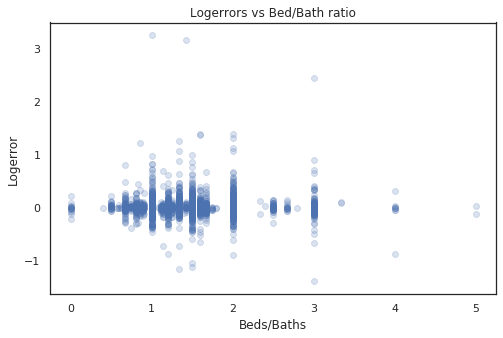

In [60]:
# Plot bed/bath ratio vs logerror - any difference for outliers
plt.figure(figsize=(8,5))
plt.scatter(df_train.bedroomcnt/df_train.bathroomcnt,df_train.logerror, alpha=0.2)
plt.xlabel('Beds/Baths')
plt.ylabel('Logerror')
plt.title('Logerrors vs Bed/Bath ratio')
plt.show()

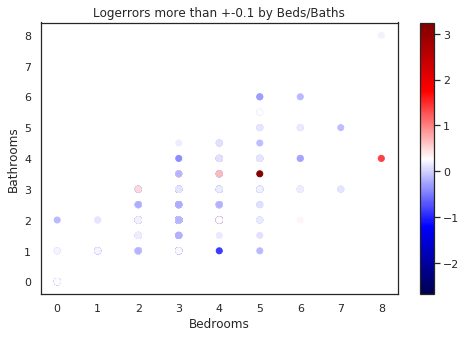

In [61]:
# Plot beds and baths vs logerror - any difference for outliers
plt.figure(figsize=(8,5))
plt.scatter(df_train[np.abs(df_train.logerror)>=0.1].bedroomcnt,df_train[np.abs(df_train.logerror)>=0.1].bathroomcnt,c=df_train[np.abs(df_train.logerror)>=0.1].logerror, cmap=plt.get_cmap('seismic'))
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')
plt.title('Logerrors more than +-0.1 by Beds/Baths')
plt.colorbar()
plt.show()

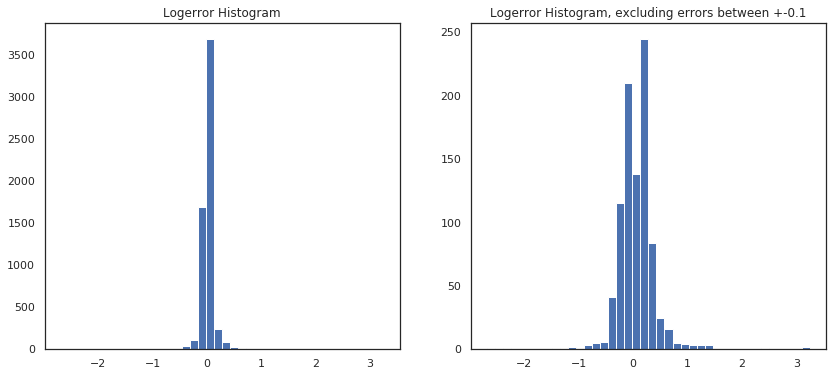

In [62]:
# plot histograms of Logerrors
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax.flatten()
ax[0].hist(df_train.logerror,bins=40)
ax[0].set_title("Logerror Histogram")
ax[1].hist(df_train.logerror[np.abs(df_train.logerror) >= 0.1],bins=40)
ax[1].set_title("Logerror Histogram, excluding errors between +-0.1")
plt.show()

/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


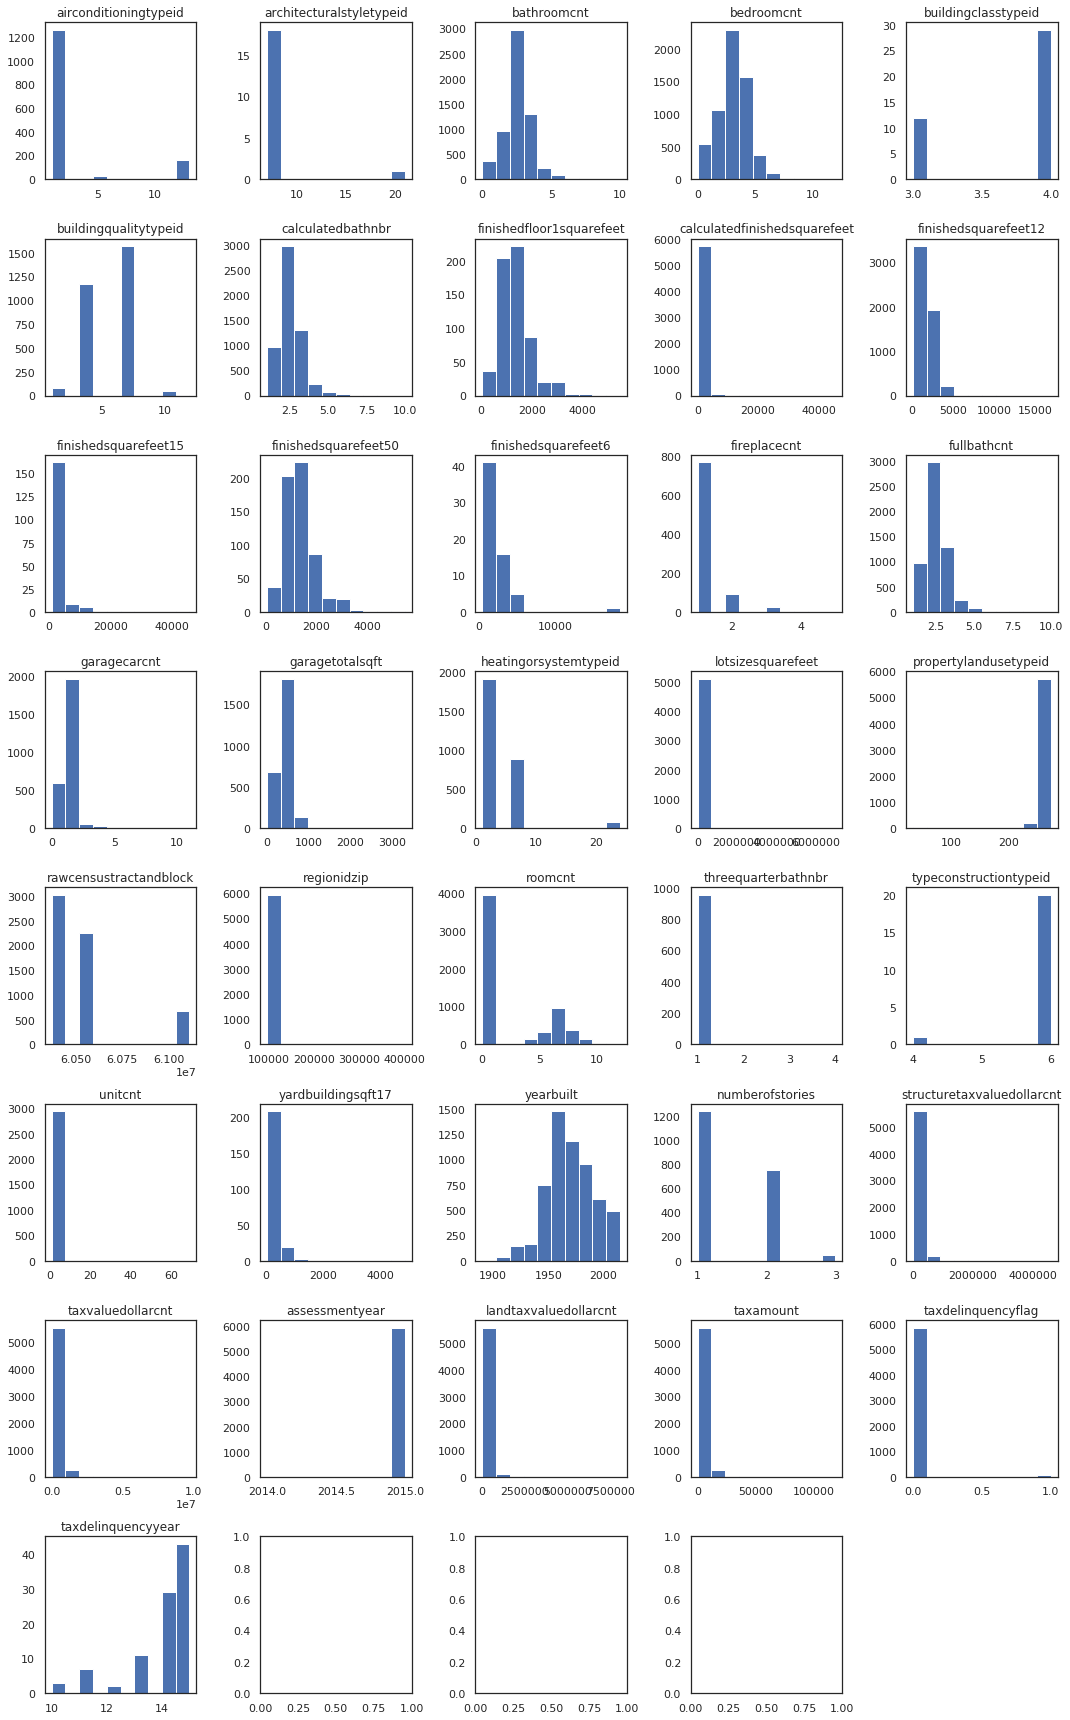

In [63]:
# Plot histograms of the columns of interest that aren't binomial or way too many categories
fig, ax = plt.subplots(8,5, figsize=(15,24))
ax = ax.flatten()
i = 0
for c in df_train.iloc[:,0:48].columns:
    if c in ['decktypeid','hashottuborspa','poolcnt','pooltypeid10','pooltypeid2','pooltypeid7','propertyzoningdesc',
             'propertycountylandusecode','regionidcity','regionidcounty','regionidneighborhood','fireplaceflag',
             'censustractandblock','latitude','longitude']:
        continue
    ax[i].hist(df_train[c])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(c)
    i+=1

plt.delaxes(ax[39])
plt.tight_layout()
plt.show()

## <font color=green> EH - Trying dimensionality reduction (PCA) on subsets of data </font>
We experiment with using PCA to group similar data (e.g. pool variables into a single dimension) then use the reduced projections moving forward

In [64]:
df_train.head()

,airconditioningtypeid,architecturalstyletypeid,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,latlng,city,county,county_city
parcelid,,,,,,,,,,,,,,,,,,,,,
13888773,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,NaN,948.0,...,6274.64,0,NaN,6.059063e+13,-0.0715,2016-07-12,"33.604554,-117.903887",Newport Beach,Orange County,"(Orange County, Newport Beach)"
14276329,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2642.0,...,29461.54,0,NaN,6.059063e+13,0.0334,2016-07-18,"33.609528,-117.91101",Newport Beach,Orange County,"(Orange County, Newport Beach)"
12819251,NaN,NaN,2.0,3.0,NaN,7.0,2.0,NaN,NaN,1196.0,...,4684.75,0,NaN,6.037409e+13,-0.0629,2016-07-07,"34.013292,-117.974435",Hacienda Heights,Los Angeles County,"(Los Angeles County, Hacienda Heights)"
14379644,13.0,NaN,3.0,5.0,NaN,NaN,3.0,NaN,NaN,2584.0,...,2627.98,0,NaN,6.059032e+13,0.4001,2016-07-18,"33.60817,-117.68117",Mission Viejo,Orange County,"(Orange County, Mission Viejo)"
14487409,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,NaN,2478.0,...,3911.26,0,NaN,6.059032e+13,0.0573,2016-07-19,"33.619986,-117.651463",Mission Viejo,Orange County,"(Orange County, Mission Viejo)"


In [65]:
# double check data types and shape
# df_train.dtypes
# df_train.shape

In [66]:
# look at different groups of similar variables to understand if possible to combine
sqft = df_train[["finishedfloor1squarefeet", "calculatedfinishedsquarefeet",  "finishedsquarefeet12", "finishedsquarefeet15",
                 "finishedsquarefeet50", "finishedsquarefeet6"]]

garage = df_train[["garagecarcnt", "garagetotalsqft"]]

pool = df_train[["poolcnt", "pooltypeid7"]]

values = df_train[["structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]]

region = df_train[["regionidcounty", "regionidcity", "regionidzip", "regionidneighborhood"]]


In [67]:
# replace NaN values with the mean of each column
sqft = sqft.fillna(sqft.mean())
garage = garage.fillna(garage.mean())
pool = pool.fillna(pool.mean())
values = values.fillna(values.mean())
region = region.fillna(region.mean())

In [89]:
# project grouped data into 1 dimension
sqft_projected = PCA(n_components = 1).fit_transform(sqft)
garage_projected = PCA(n_components = 1).fit_transform(garage)
values_projected = PCA(n_components = 1).fit_transform(values)
region_projected = PCA(n_components = 1).fit_transform(region)

# probably can't project pool data because the replacement value is all 1, so thre is no point of comparison
pool_projected = PCA(n_components = 1).fit_transform(pool)


/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [180]:
import importlib
importlib.reload(gauntlet)

<module 'gauntlet' from '/home/austin/Documents/School/Summer2019/W207_MachineLearning/git_repos/final_project/gauntlet.py'>

In [136]:
def concat_tables(*args):
    out_arr = []
    for arg in args:
        arg_np = np.array(arg)
        out_arr.append(arg_np)
        
    return np.concatenate(out_arr, axis=1)

full_data = concat_tables(sqft, garage, values, region)
projected_data = concat_tables(sqft_projected, garage_projected, values_projected, region_projected)
labels = df_train['logerror']

In [141]:
gauntlet.compare_datasets(full_data, labels, projected_data, labels)

Dataset 1 Row Count: 5953, Feature Count: 16
Dataset 2 Row Count: 5953, Feature Count: 4
Cross validating and comparing...

Model: mlp, Data 1 error: 151.115, Data 2 error: 20.01, change: -86.760%
Model: knn, Data 1 error: 0.083, Data 2 error: 0.09, change: 6.658%
Model: tree, Data 1 error: 0.108, Data 2 error: 0.12, change: 11.107%
Model: gbt, Data 1 error: 0.070, Data 2 error: 0.07, change: -1.014%


In [162]:
from sklearn.neural_network import MLPRegressor
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, full_data, labels)
print(f'MLP Error: {err_:.3f}, Error std: {err_std_:.2f}')

[ 434.64383758  533.98154808  535.39815121  346.01301751 1177.30628991]
MLP Error: 605.469, Error std: 294.45


It looks like the MLPRegressor is just bad. Maybe this could be improved via fiddling with the network architecture?

In [166]:
# first let's try our rule of thumb
num_in_and_out = int((full_data.shape[1] + 1) * (2/3))
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, full_data, labels, hidden_layer_sizes=[num_in_and_out, 5], max_iter=1000)
print(f'MLP Improved Error: {err_:.3f}, Error std: {err_std_:.2f}')

[  6.41121572   9.53210675 157.81751466   1.61476112 167.36717136]
MLP Improved Error: 68.549, Error std: 76.89


That's a definite improvement. What if we tried it with the smaller data? Note that we are keeping the network architecture consistent.

In [168]:
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, projected_data, labels, hidden_layer_sizes=[num_in_and_out, 5], max_iter=1000)
print(f'MLP Improved Error: {err_:.3f}, Error std: {err_std_:.2f}')

[  35.41467871    2.93149467 1269.29243163   20.19866206   99.86763352]
MLP Improved Error: 285.541, Error std: 492.97


Nope, still pretty bad. Now let's take a look at Gradient Boosting Trees, as this appears to have performed pretty well.

/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


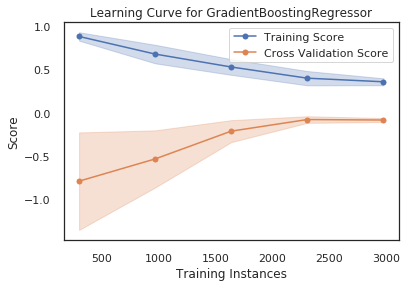

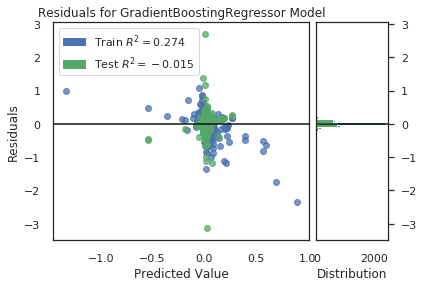

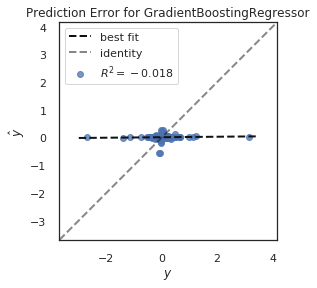

In [175]:
from sklearn.ensemble import GradientBoostingRegressor
gauntlet.viz_model(GradientBoostingRegressor, full_data, labels)

It is very interesting that the training score decreases sharply as the amount of training data increases. This appears to indicate noise in the training data. The other thing that is immediately noticable in the prediction error plot is how grouped together the errors are around 0. Let's see what happens with the reduced dataset

In [184]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
# gauntlet.viz_model(GradientBoostingRegressor, projected_data, labels)

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## t-SNE Clustering
We perform t-SNE clustering to identify if there is a visible grouping of higher `logerror`s. While t-SNE is not great for hard analysis, it is a good visualization utility and would allow us to identify if there is a clear grouping of variables with larger logerrors

In [69]:
df_train.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'bathroomcnt',
       'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude',
       'lotsizesquarefeet', 'poolcnt', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtax

In [72]:
# remove categorical variables for now
# AB - removed censustractandblock, rawcensustractandblock, and binary features (hashottuborspa, fireplaceflag, taxdelinquincyflag)
tsne_train_columns = [
       'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'lotsizesquarefeet', 'poolcnt', 'roomcnt',
       'threequarterbathnbr', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 
       'taxdelinquencyyear', 'logerror',
       'transactiondate']
tsne_train_df = df_train[tsne_train_columns].copy()

tsne_train_df['transactiondate'] = tsne_train_df['transactiondate'].astype(np.int64)

drop_columns = []
for column in tsne_train_df.columns:
    if (~tsne_train_df[column].isna()).sum() > 5000:
        # Normalize all features here
        if column != 'logerror':
            tsne_train_df[column] = (tsne_train_df[column] - tsne_train_df[column].mean()) / tsne_train_df[column].std()
        continue
    
    drop_columns.append(column)
tsne_train_df.drop(drop_columns, axis='columns', inplace=True)


#tsne_train_df['transactiondate'] = (tsne_train_df['transactiondate'] - tsne_train_df['transactiondate'].mean()) / tsne_train_df['transactiondate'].std()
#tsne_train_df['assessmentyear'] = (tsne_train_df['assessmentyear'] - tsne_train_df['assessmentyear'].mean()) / tsne_train_df['assessmentyear'].std()
tsne_train_df.dropna(axis='rows', inplace=True)

tsna_train_np = tsne_train_df.loc[:,tsne_train_df.columns != 'logerror']
### WARNING!!! THIS TAKES A WHILE!!!
tsne_results = TSNE(n_components=2, verbose=1).fit_transform(tsna_train_np)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4830 samples in 0.009s...
[t-SNE] Computed neighbors for 4830 samples in 0.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4830
[t-SNE] Computed conditional probabilities for sample 2000 / 4830
[t-SNE] Computed conditional probabilities for sample 3000 / 4830
[t-SNE] Computed conditional probabilities for sample 4000 / 4830
[t-SNE] Computed conditional probabilities for sample 4830 / 4830
[t-SNE] Mean sigma: 0.467029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.257675
[t-SNE] KL divergence after 1000 iterations: 0.810203


In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha = .8, c = np.abs(tsne_train_df['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

As we saw in the earlier `logerror` distribution, a very large portion of the logerrors are extremely close to 0, making the colormapping difficult to understand. Let's observe the values both in and outside of these limits

In [ ]:
# filter out high logerrors
mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

In [ ]:
# filter out low logerrors
mask = np.abs(tsne_train_df['logerror']) > 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

Unfortunately it doesn't look like there is a very large tendency for clusters to have similar logerror values, which means that this task will be pretty difficult. One very interesting thing to note is the linearity in the clusters that were created. Typically these clusters are both long and fat, but in this distribution it appears to be very tight and skinny. I'm not sure what this indicates.

In [ ]:
# AB  - crazy thought - what if we take the log(logerror) to better visualize?
#mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df #[mask]
tsne_results_sub = tsne_results #[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = -np.log(np.abs(tsne_train_df_sub['logerror'])), cmap = 'inferno')
cbar = plt.colorbar()